# EDA FOR THE DATASET


The World Restaurants dataset is a large-scale, real-world collection of restaurant reviews and associated metadata sourced from various users and venues globally. It is composed of four main CSV files: reviews.csv, which contains written reviews, ratings, categories, and timestamps; review_sentiments.csv, which includes sentiment analysis scores derived from those reviews (overall sentiment, emotion scores, and magnitudes); users.csv, which provides anonymized user profiles with attributes like education, location, and job information; and places.csv, which holds metadata about the restaurants, such as name, price range, phone number, and whether the establishment is currently closed. Together, this dataset offers a rich and diverse foundation for building recommendation systems, sentiment analysis models, and consumer behavior studies in the food and hospitality domain.



### Step 0: Load imports


In [183]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS
import ast
import warnings
warnings.filterwarnings("ignore")
import plotly.io as pio
import os
import glob
from sklearn.cluster import KMeans


### Step 1: Load the Dataset from Kaggle 


In [8]:
# Authenticate Kaggle API
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

# Download and unzip dataset
dataset_path = 'danielkumlin/world-restaurants'
api.dataset_download_files(dataset_path, path='data/', unzip=True)

# List all CSV files
csv_files = glob.glob('data/*.csv')
print("Downloaded CSV files:", csv_files)



Dataset URL: https://www.kaggle.com/datasets/danielkumlin/world-restaurants
Downloaded CSV files: ['data/reviews.csv', 'data/users.csv', 'data/places.csv', 'data/review_sentiments.csv']


### Step 2: Decreasing and merging dataset

This dataset we created and sourced is extremally large with around 700,000 datapoints, therefore we will be using around 30% for the original.

In [46]:
print("Reviews columns:", reviews.columns.tolist())
print("Sentiments columns:", sentiments.columns.tolist())
print("Restaurants columns:", places.columns.tolist())
print("user columns:", users.columns.tolist())

Reviews columns: ['rating', 'reviewerName', 'reviewText', 'categories', 'reviewTime', 'unixReviewTime', 'formattedDate', 'gPlusPlaceId', 'gPlusUserId']
Sentiments columns: ['review_id', 'user_id', 'restaurant_id', 'overall_score', 'overall_magnitude', 'food_score', 'service_score', 'value_score', 'ambiance_score', 'emotions']
Restaurants columns: ['name', 'price', 'phone', 'closed', 'gPlusPlaceId', 'address_line1', 'address_line2', 'address_line3', 'latitude', 'longitude', 'hours_monday', 'hours_tuesday', 'hours_wednesday', 'hours_thursday', 'hours_friday', 'hours_saturday', 'hours_sunday']
user columns: ['userName', 'currentPlace', 'education', 'gPlusUserId', 'jobs', 'previousPlaces']


To create a comprehensive and unified dataset suitable for building a recommendation system, we merged four separate CSV files from the *World Restaurants* dataset using common identifiers. We began with the `review_sentiments.csv` file, which provided sentiment scores for user reviews, and merged it with `reviews.csv` by matching `user_id` and `restaurant_id` from the sentiment file with `gPlusUserId` and `gPlusPlaceId` in the reviews file. This allowed us to attach actual review text, ratings, and categories to each sentiment-labeled record. We then enriched this merged dataset by joining it with `users.csv` using `user_id` and `gPlusUserId`, integrating user-level metadata such as current location, education, and job. Finally, we added restaurant-specific information like name, price range, and operating status by merging with `places.csv` on `restaurant_id` and `gPlusPlaceId`. The result is a clean and structured dataset combining reviews, sentiments, user profiles, and restaurant details — ideal for downstream analysis and recommendation modeling.


After merging, we further cleaned the data by keeping only reviews written in English, detected using the `langdetect` library, to ensure language consistency for NLP-based analysis. We also filtered out users with fewer than a minimum number of reviews (e.g., five), retaining only active users with sufficient interaction history to support reliable modeling. The result is a clean and structured dataset combining reviews, sentiments, user profiles, and restaurant details — ideal for downstream analysis and recommendation modeling.


In [58]:
import pandas as pd
import os
from langdetect import detect

# ---------- Load raw data ----------
reviews = pd.read_csv("data/reviews.csv", nrows=150000, engine='python', on_bad_lines='skip')
sentiments = pd.read_csv("data/review_sentiments.csv")
users = pd.read_csv("data/users.csv")
places = pd.read_csv("data/places.csv")

# ---------- Merge datasets ----------
df_merge = pd.merge(
    sentiments,
    reviews,
    how="left",
    left_on=["user_id", "restaurant_id"],
    right_on=["gPlusUserId", "gPlusPlaceId"]
)
df_merge = pd.merge(df_merge, users, how="left", left_on="user_id", right_on="gPlusUserId")
df_merge = pd.merge(df_merge, places, how="left", left_on="restaurant_id", right_on="gPlusPlaceId")

print("Initial merged shape:", df_merge.shape)

# ---------- Filter data ----------

# 1. Remove missing or empty review text
df_merge = df_merge[df_merge['reviewText'].notna()]
df_merge = df_merge[df_merge['reviewText'].str.strip() != ""]

# 2. Remove reviews with missing ratings
df_merge = df_merge[df_merge['rating'].notna()]

# 3. Keep only English reviews
def is_english(text):
    try:
        return detect(text) == "en"
    except:
        return False

print("Detecting English reviews — this may take a few minutes...")
df_merge["is_english"] = df_merge["reviewText"].apply(is_english)
df_merge = df_merge[df_merge["is_english"] == True]
df_merge.drop(columns=["is_english"], inplace=True)

# 4. Keep users with at least N reviews
min_reviews = 5
user_counts = df_merge["user_id"].value_counts()
valid_users = user_counts[user_counts >= min_reviews].index
df_merge = df_merge[df_merge["user_id"].isin(valid_users)]

# ---------- Save final cleaned dataset ----------
output_dir = "merged_dataset"
os.makedirs(output_dir, exist_ok=True)

final_path = os.path.join(output_dir, "merge_df.csv")
df_merge.to_csv(final_path, index=False)

print(f"\n Final cleaned dataset saved to: {final_path}")
print("Final shape:", df_merge.shape)
print(df_merge[["user_id", "rating", "reviewText"]].sample(5))


Initial merged shape: (487787, 42)
Detecting English reviews — this may take a few minutes...

 Final cleaned dataset saved to: merged_dataset/merge_df.csv
Final shape: (24883, 42)
                     user_id rating  \
4382   100009422787049665165    3.0   
33731  100078954935072209039    4.0   
51831  100120827762398154737    3.0   
9427   100020474110561536283    3.0   
35400  100083448224418184796    2.0   

                                              reviewText  
4382   despite all the negativity this restaurant has...  
33731  This place has got one of the better tastes am...  
51831                                 not worth the hype  
9427   underwhelmed.... went to cook & brown for brun...  
35400  Where do I start..?\nIt's free for the general...  


### Step 3: Pre Processing and Cleaning 


In [102]:
# Review the dataset columns and data types
print("\nColumns in dataset:\n", df_merge.columns.tolist())
print("\nData types and nulls:\n")
df_merge.info()


Columns in dataset:
 ['review_id', 'user_id', 'restaurant_id', 'overall_score', 'overall_magnitude', 'food_score', 'service_score', 'value_score', 'ambiance_score', 'emotions', 'rating', 'reviewerName', 'reviewText', 'categories', 'reviewTime', 'unixReviewTime', 'formattedDate', 'gPlusPlaceId_x', 'gPlusUserId_x', 'userName', 'currentPlace', 'education', 'gPlusUserId_y', 'jobs', 'previousPlaces', 'name', 'price', 'phone', 'closed', 'gPlusPlaceId_y', 'address_line1', 'address_line2', 'address_line3', 'latitude', 'longitude', 'hours_monday', 'hours_tuesday', 'hours_wednesday', 'hours_thursday', 'hours_friday', 'hours_saturday', 'hours_sunday']

Data types and nulls:

<class 'pandas.core.frame.DataFrame'>
Index: 24883 entries, 12 to 103068
Data columns (total 42 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   review_id          24883 non-null  object 
 1   user_id            24883 non-null  object 
 2   restaurant_id      2488

The output shown above provides a structural overview of the `df_merge` DataFrame after the datasets were merged and preliminary cleaning steps were applied. It displays the number of rows (24,883 entries) and columns (42 features), along with each column’s data type and the count of non-null values. This summary is useful for verifying that the merge was successful and identifying any remaining missing values. Key columns such as `review_id`, `user_id`, `restaurant_id`, `rating`, and `reviewText` are fully populated, indicating a strong base for further analysis. However, some columns still contain missing values (e.g., `hours_saturday`, `address_line2`, `categories`), which will need to be handled during the final data cleaning process. This step ensures we understand the dataset’s structure and are ready to proceed with feature engineering and modeling.


In [83]:
# Check for missing values 
missing = df_merge.isnull().sum()
missing = missing[missing > 0]
print("\n Missing values:\n", missing)



 Missing values:
 categories          1289
reviewTime          1162
unixReviewTime      1162
formattedDate       1162
userName             982
currentPlace       15535
education            989
gPlusUserId_y        982
jobs               15104
previousPlaces     18164
name                  15
price              14483
phone                982
closed                15
gPlusPlaceId_y        15
address_line1         15
address_line2        362
address_line3      19352
latitude             211
longitude            211
hours_monday        6810
hours_tuesday       6810
hours_wednesday     6810
hours_thursday      6810
hours_friday        6810
hours_saturday      6810
hours_sunday        6810
dtype: int64


The output above shows a summary of the missing values in the `df_merge` DataFrame. This was generated using `df_merge.isnull().sum()` to calculate the total number of missing entries in each column, filtered to show only columns where missing values exist. From the output, we can observe that some fields have a small amount of missing data (e.g., `categories`, `reviewTime`, `username`), while others—like `previousPlaces`, `phone`, and various `hours_*` columns—contain a much higher number of missing values. Identifying these gaps is a critical part of the cleaning process, helping determine which columns should be retained and imputed, and which can be safely dropped. This diagnostic step informs how we handle incomplete data to ensure the integrity of the final dataset.


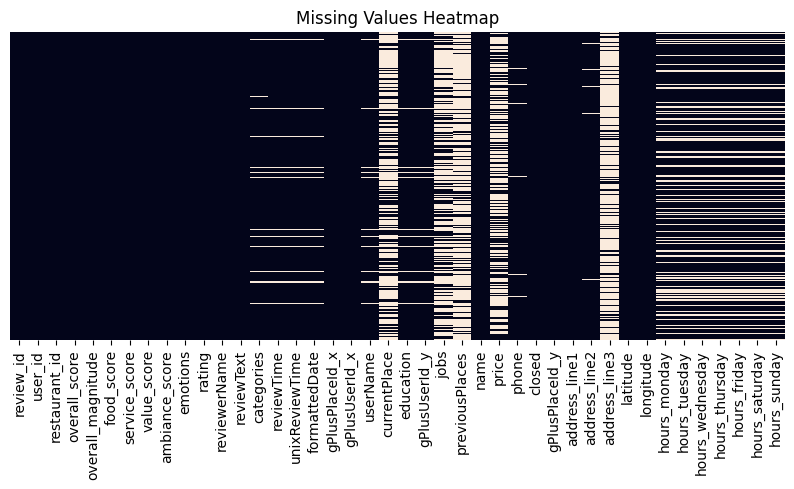

In [84]:
plt.figure(figsize=(10, 4))
sns.heatmap(df_merge.isnull(), cbar=False, yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()

The visualization above is a heatmap showing the distribution of missing values across the dataset. It was generated using `seaborn.heatmap()` on the result of `df_merge.isnull()`, which highlights the presence of null (missing) values for each column. In this heatmap, each white line represents a missing value in a specific row and column, while black areas indicate complete data.

From the heatmap, we can observe that:
- Some columns (like `address_line2`, business hour fields, and `jobs`) have significant portions of missing data, as shown by solid vertical bands of white.
- Other columns (like `review_id`, `user_id`, `rating`, and `reviewText`) are mostly complete, appearing fully black.

This visual summary is especially helpful for quickly identifying columns that might need to be dropped, filled, or handled carefully during data cleaning. It complements the numeric null count and provides an intuitive way to assess overall data quality before preprocessing.

In [93]:
# Create a copy to work on safely
df_clean = df_merge.copy()

In [94]:
cols_to_drop = [
    'address_line3', 'hours_monday', 'hours_tuesday', 'hours_wednesday',
    'hours_thursday', 'hours_friday', 'hours_saturday', 'hours_sunday', 'adress_line3',
    'phone', 'previousPlaces', 'jobs', 'currentPlace', 'usernames', 'gPlusPlaceId' # these last two are things we dont need due to user id
]
df_clean.drop(columns=[col for col in cols_to_drop if col in df_merge.columns], inplace=True)


A list of columns with excessive missing data or little analytical value (such as business hours, address line 3, phone, previous places, and duplicate identifiers like `gPlusPlaceId`) is compiled and removed from `df_clean`. This reduces noise in the dataset and improves overall quality for modeling.


In [95]:
#Fill missing values for categorical columns with "unknown"
df_clean["price"].fillna("unknown", inplace=True)
df_clean["education"].fillna("unknown", inplace=True)
df_clean["closed"].fillna(False, inplace=True)
df_clean["categories"].fillna("unknown", inplace=True) # we can try to chang this to nlp if we want idk



Several important categorical columns — including `price`, `education`, `closed`, and `categories` — are filled with the placeholder `"unknown"` or `False` for logical binary values like `closed`. This ensures consistency and avoids issues during encoding or grouping.


In [96]:
# Fill missing values for numeric columns
num_cols = ["overall_score", "overall_magnitude", "food_score", "service_score", "value_score", "ambiance_score"]
for col in num_cols:
    if col in df_clean.columns:
        df_clean[col].fillna(0, inplace=True)

df_clean["address_line2"].fillna("unknown", inplace=True)

For numerical columns related to sentiment and review scoring (e.g. `overall_score`, `food_score`, etc.), missing values are filled with `0`. This approach is suitable when the absence of data can logically be interpreted as no score or a neutral baseline.


In [97]:
#Drop rows if critical text/tags are missing
df_clean = df_clean[df_clean["reviewText"].notna()]
df_clean = df_clean[df_clean["reviewText"].str.strip() != ""]
df_clean = df_clean[df_clean["rating"].notna()]
#Drop rows where timestamps are missing (critical for time-based modeling)
df_clean = df_clean[df_clean["reviewTime"].notna()]
df_clean = df_clean[df_clean["unixReviewTime"].notna()]
df_clean = df_clean[df_clean["formattedDate"].notna()]


Rows with missing or empty values in key review fields such as `reviewText`, `rating`, `reviewTime`, `unixReviewTime`, and `formattedDate` are dropped. These fields are essential for sentiment analysis, user behavior tracking, and time-based modeling. Retaining rows without this information would compromise the consistency of the dataset.


In [99]:
# Drop rows with missing place info (only 15 rows — safe)
df_clean = df_clean[df_clean["name"].notna()]
df_clean = df_clean[df_clean["gPlusPlaceId_y"].notna()]
df_clean = df_clean[df_clean["address_line1"].notna()]


# Drop rows with missing latitude/longitude (only 211 rows)
df_clean = df_clean[df_clean["latitude"].notna()]
df_clean = df_clean[df_clean["longitude"].notna()]

Rows missing basic restaurant identifiers such as `name`, `gPlusPlaceId_y`, or `address_line1` are dropped. Since only 15 rows are affected, this cleanup step is safe and ensures that every review is linked to a well-defined place.


Latitude and longitude are essential if the dataset is to be used for location-based recommendations or map visualizations. Only 211 rows are affected, so dropping them avoids introducing noise or nulls in spatial analysis.


In [105]:
# 4. Drop duplicates 
before = df_clean.shape[0]
df_clean.drop_duplicates(inplace=True)
after = df_clean.shape[0]
print(f"\n Removed {before - after} duplicate rows")


 Removed 0 duplicate rows


Finally, any duplicate rows are removed to ensure uniqueness in the dataset. The code also prints the number of duplicates removed by comparing the DataFrame shape before and after the operation.


In [100]:
#Final Check for Any Remaining Missing Values
missing = df_clean.isnull().sum()
print("Remaining missing values:\n", missing[missing > 0])


Remaining missing values:
 Series([], dtype: int64)


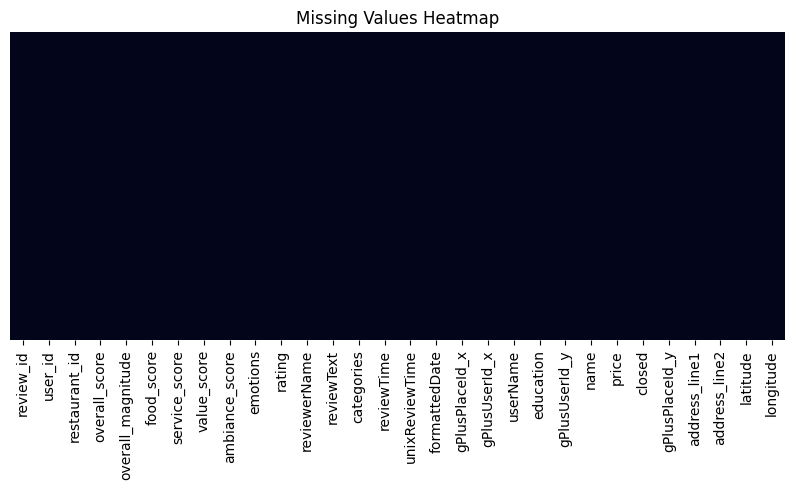

In [101]:
plt.figure(figsize=(10, 4))
sns.heatmap(df_clean.isnull(), cbar=False, yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()

no more missing values!! :)

In [106]:
# ---------- 1. Review the dataset ----------
print("\nColumns in clean dataset:\n", df_clean.columns.tolist())
print("\nData types and nulls:\n")
df_clean.info()


Columns in clean dataset:
 ['review_id', 'user_id', 'restaurant_id', 'overall_score', 'overall_magnitude', 'food_score', 'service_score', 'value_score', 'ambiance_score', 'emotions', 'rating', 'reviewerName', 'reviewText', 'categories', 'reviewTime', 'unixReviewTime', 'formattedDate', 'gPlusPlaceId_x', 'gPlusUserId_x', 'userName', 'education', 'gPlusUserId_y', 'name', 'price', 'closed', 'gPlusPlaceId_y', 'address_line1', 'address_line2', 'latitude', 'longitude']

Data types and nulls:

<class 'pandas.core.frame.DataFrame'>
Index: 23516 entries, 12 to 103068
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   review_id          23516 non-null  object 
 1   user_id            23516 non-null  object 
 2   restaurant_id      23516 non-null  object 
 3   overall_score      23516 non-null  float64
 4   overall_magnitude  23516 non-null  float64
 5   food_score         23516 non-null  float64
 6   service_score

In [108]:
# Create the folder if it doesn't exist
clean_dir = "clean_dataset"
os.makedirs(clean_dir, exist_ok=True)

# Save the cleaned DataFrame
clean_path = os.path.join(clean_dir, "clean_restaurant_data.csv")
df_clean.to_csv(clean_path, index=False)

print(f"\nCleaned dataset saved to: {clean_path}")



Cleaned dataset saved to: clean_dataset/clean_restaurant_data.csv


Through a comprehensive data cleaning and preprocessing pipeline, we successfully transformed a raw, multi-source dataset into a clean and structured format suitable for analysis and recommendation modeling. We began by merging four separate datasets — reviews, sentiments, users, and places — using unique identifiers such as `user_id` and `restaurant_id` to consolidate review content with metadata about users and restaurants. 

Next, we conducted detailed missing value analysis using both statistical summaries and visual heatmaps, which guided our strategy for handling incomplete data. We removed irrelevant or excessively incomplete columns, filled missing values in categorical fields (like `price` and `education`) with `"unknown"`, and replaced missing numeric sentiment scores with `0` to represent neutrality. We also filtered out reviews missing critical text, timestamps, or geographic data, and eliminated duplicates to ensure the integrity of the dataset.

The resulting dataset is clean, complete, and ready for exploratory data analysis, feature engineering, and the development of a personalized restaurant recommendation system.

### Step 4: Basic exploration



In [109]:
print("\n=== Dataset Overview ===")
print(df_clean.shape)
print(df_clean.columns)
print(df_clean.dtypes)
print(df_clean.describe(include='all'))


=== Dataset Overview ===
(23516, 30)
Index(['review_id', 'user_id', 'restaurant_id', 'overall_score',
       'overall_magnitude', 'food_score', 'service_score', 'value_score',
       'ambiance_score', 'emotions', 'rating', 'reviewerName', 'reviewText',
       'categories', 'reviewTime', 'unixReviewTime', 'formattedDate',
       'gPlusPlaceId_x', 'gPlusUserId_x', 'userName', 'education',
       'gPlusUserId_y', 'name', 'price', 'closed', 'gPlusPlaceId_y',
       'address_line1', 'address_line2', 'latitude', 'longitude'],
      dtype='object')
review_id             object
user_id               object
restaurant_id         object
overall_score        float64
overall_magnitude    float64
food_score           float64
service_score        float64
value_score          float64
ambiance_score       float64
emotions              object
rating                object
reviewerName          object
reviewText            object
categories            object
reviewTime            object
unixReviewTime  

=== Basic Stats: Ratings ===
count     23516
unique        5
top         5.0
freq      10763
Name: rating, dtype: object


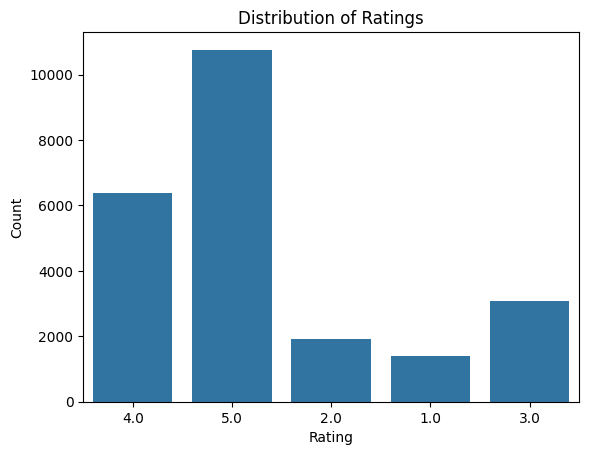

In [115]:
print("=== Basic Stats: Ratings ===")
print(df_clean['rating'].describe())
sns.countplot(x='rating', data=df_clean)
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()



=== Sentiment Score Distributions ===


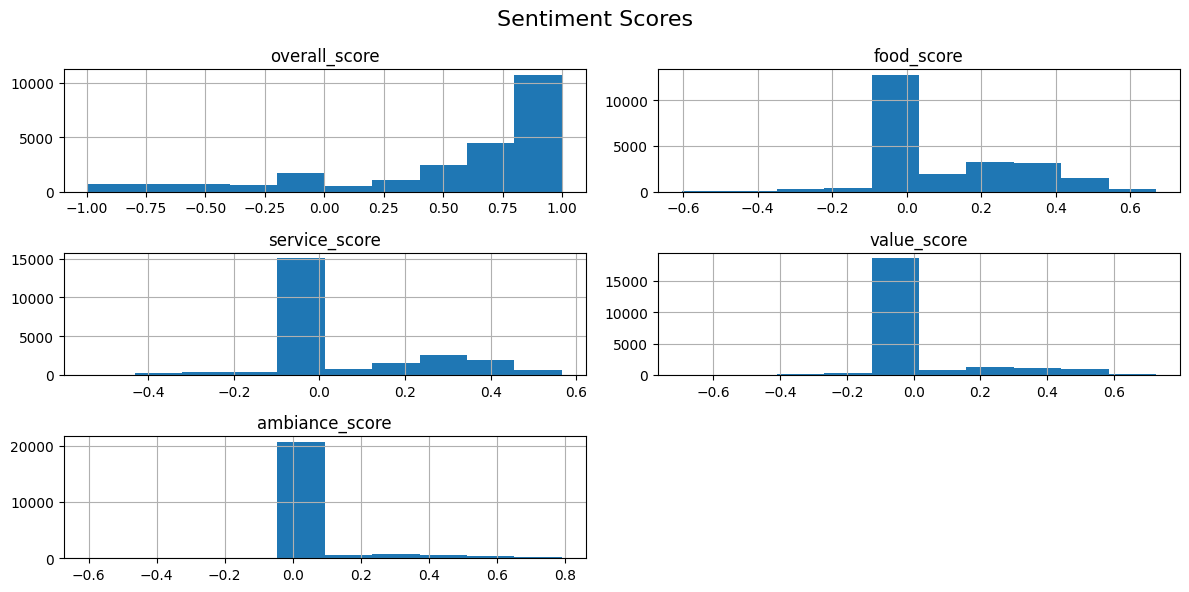

In [111]:
### Step 3: Sentiment Scores
sentiment_scores = ['overall_score', 'food_score', 'service_score', 'value_score', 'ambiance_score']
print("\n=== Sentiment Score Distributions ===")
df_clean[sentiment_scores].hist(figsize=(12, 6))
plt.suptitle("Sentiment Scores", fontsize=16)
plt.tight_layout()
plt.show()

In [120]:
# Sentiment Subscores
sentiment_cols = ['overall_score', 'food_score', 'service_score', 'value_score', 'ambiance_score']
print("\n=== Basic Stats: Sentiment Scores ===")
print(df_clean[sentiment_cols].describe())


=== Basic Stats: Sentiment Scores ===
       overall_score    food_score  service_score   value_score  \
count   23516.000000  23516.000000   23516.000000  23516.000000   
mean        0.544058      0.112110       0.080849      0.053606   
std         0.506367      0.179436       0.167968      0.155244   
min        -0.996800     -0.604261      -0.542461     -0.695063   
25%         0.384075      0.000000       0.000000      0.000000   
50%         0.763000      0.000000       0.000000      0.000000   
75%         0.911000      0.253847       0.190056      0.000000   
max         0.999700      0.669952       0.566458      0.727076   

       ambiance_score  
count    23516.000000  
mean         0.038821  
std          0.136805  
min         -0.603926  
25%          0.000000  
50%          0.000000  
75%          0.000000  
max          0.791227  


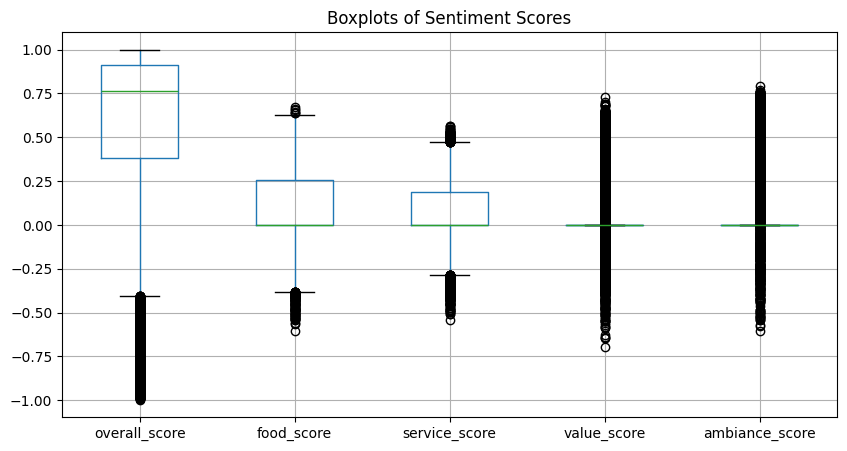

In [122]:

df_clean[sentiment_cols].boxplot(figsize=(10,5))
plt.title("Boxplots of Sentiment Scores")
plt.show()


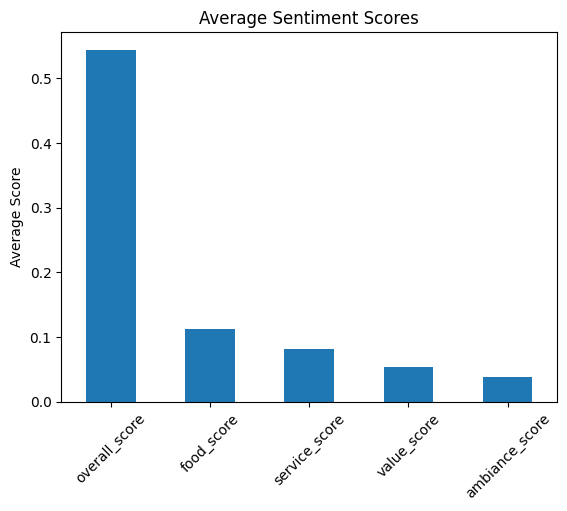

In [118]:
df_clean[sentiment_cols].mean().plot(kind='bar')
plt.title("Average Sentiment Scores")
plt.ylabel("Average Score")
plt.xticks(rotation=45)
plt.show()

In [150]:
# 5. Interaction Matrix & Sparsity
num_users = df_clean['user_id'].nunique()
num_items = df_clean['restaurant_id'].nunique()
total_ratings = df_clean.shape[0]
sparsity = 1 - (total_ratings / (num_users * num_items))
print(f"Users: {num_users}, Restaurants: {num_items}, Total Ratings: {total_ratings}")
print(f"Sparsity of interaction matrix: {sparsity:.2%}")

Users: 2181, Restaurants: 22766, Total Ratings: 23516
Sparsity of interaction matrix: 99.95%


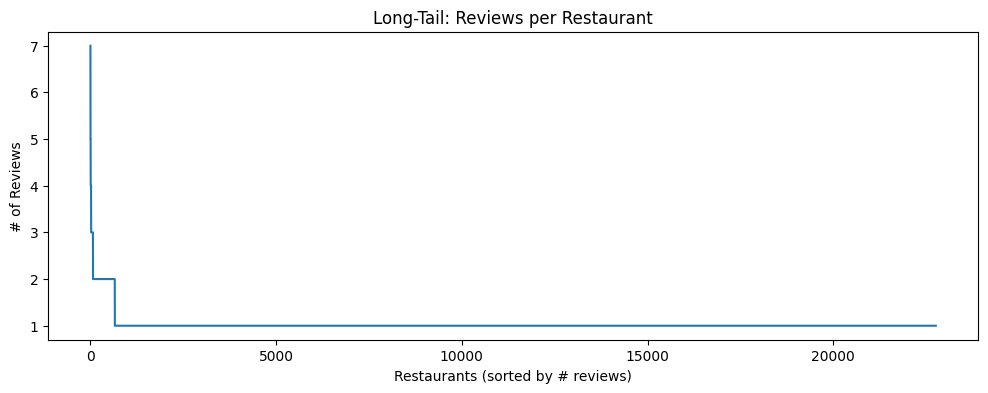

In [152]:
plt.figure(figsize=(12,4))
sns.lineplot(data=rest_freq.sort_values(ascending=False).reset_index(drop=True))
plt.title("Long-Tail: Reviews per Restaurant")
plt.xlabel("Restaurants (sorted by # reviews)")
plt.ylabel("# of Reviews")
plt.show()



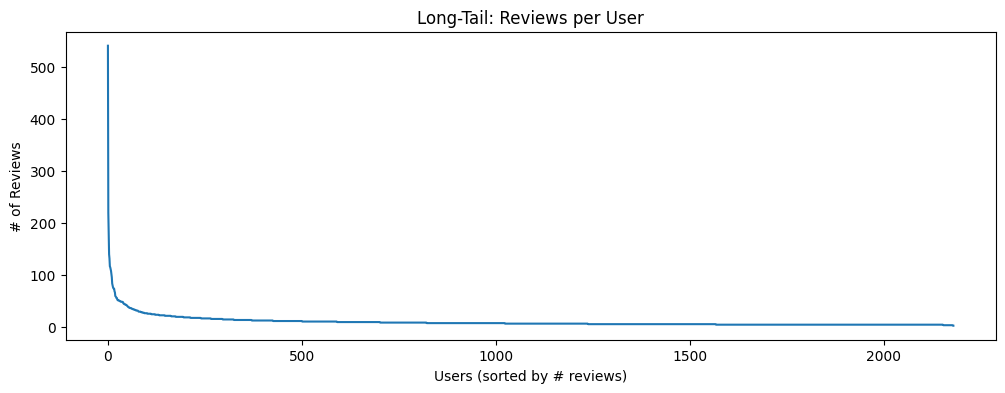

In [153]:
plt.figure(figsize=(12,4))
sns.lineplot(data=user_freq.sort_values(ascending=False).reset_index(drop=True))
plt.title("Long-Tail: Reviews per User")
plt.xlabel("Users (sorted by # reviews)")
plt.ylabel("# of Reviews")
plt.show()

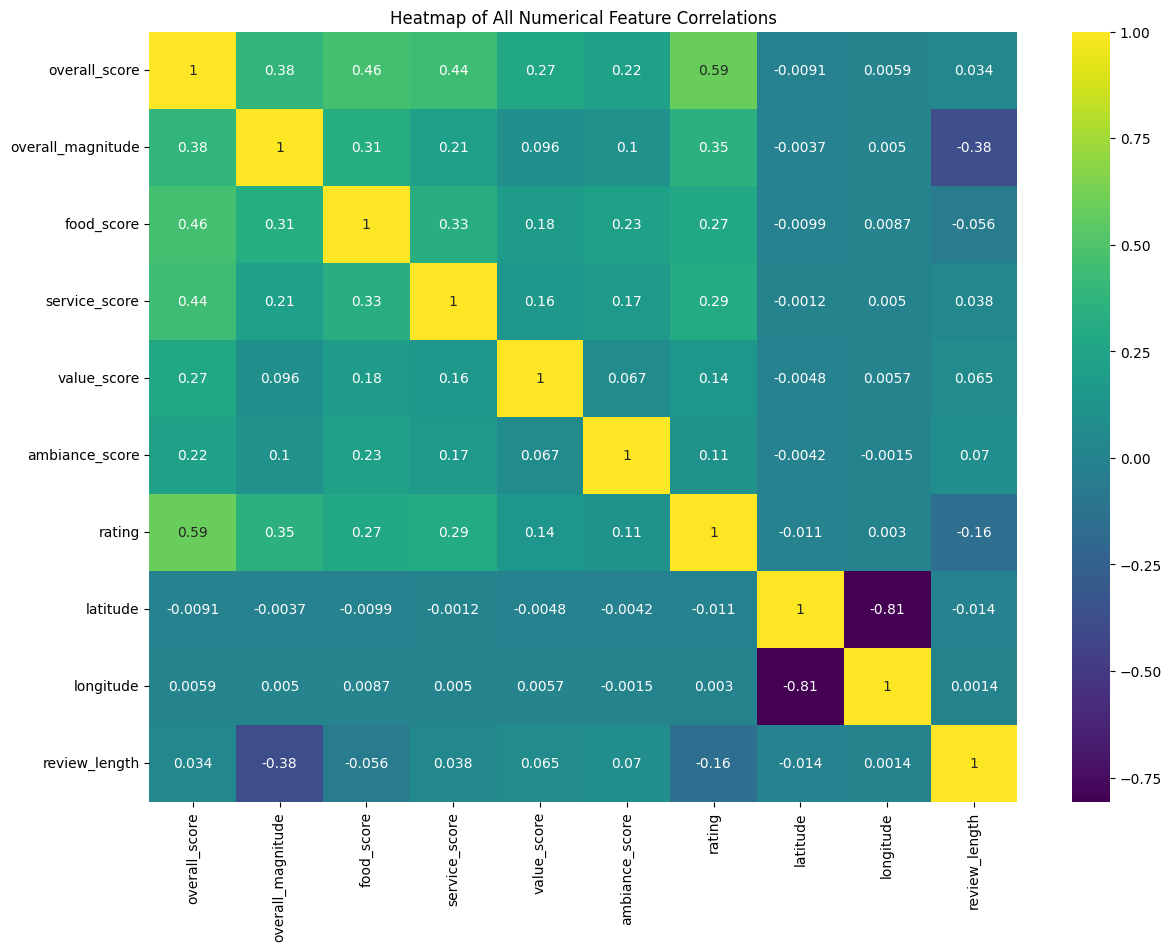

In [163]:
correlation = df_clean.select_dtypes(include=['float64', 'int64']).corr()
plt.figure(figsize=(14,10))
sns.heatmap(correlation, annot=True, cmap='viridis')
plt.title("Heatmap of All Numerical Feature Correlations")
plt.show()

### Step 5: Item Metadata Exploration


In [63]:
!pip install nbformat



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [64]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'notebook'  # or 'iframe' or 'browser'


In [169]:
# Clean out invalid coordinates
map_df = df_clean.dropna(subset=['latitude', 'longitude'])
map_df = map_df[(map_df['latitude'] != 0) & (map_df['longitude'] != 0)]
print("Total rows in df_clean:", len(df_clean))

valid_coords = df_clean.dropna(subset=['latitude', 'longitude'])
valid_coords = valid_coords[(valid_coords['latitude'] != 0) & (valid_coords['longitude'] != 0)]
print("Valid lat/lon rows:", len(valid_coords))
print(valid_coords[['name', 'latitude', 'longitude']].head())

# Now plot the interactive map
px.scatter_mapbox(
    valid_coords,
    lat="latitude",
    lon="longitude",
    hover_name="name",
    color="rating",
    zoom=1,
    center=dict(lat=0, lon=0),  # Centered on world
    mapbox_style="carto-positron",
    title="Global Map of Restaurants"
).show()

Total rows in df_clean: 23516
Valid lat/lon rows: 23516
                         name   latitude   longitude
12  Peking Chinese Restaurant  40.179159 -122.236162
13            Firehouse Pizza  40.178074 -122.235234
14          Two Buds Barbeque  40.184955 -122.186557
15           Bud's Jolly Kone  40.185961 -122.209742
16                  La Corona  40.175064 -122.242574


In [128]:
print("=== Categories ===")
print(df_clean['categories'].value_counts().head(10))

=== Categories ===
categories
Restaurant                                                   931
Hotel                                                        600
American Restaurant                                          338
Pizza Restaurant; European Restaurant; Italian Restaurant    290
Mexican Restaurant; Latin American Restaurant                281
Bar                                                          243
Coffee Shop                                                  210
Chinese Restaurant; Asian Restaurant                         208
Cafe                                                         183
Park                                                         164
Name: count, dtype: int64


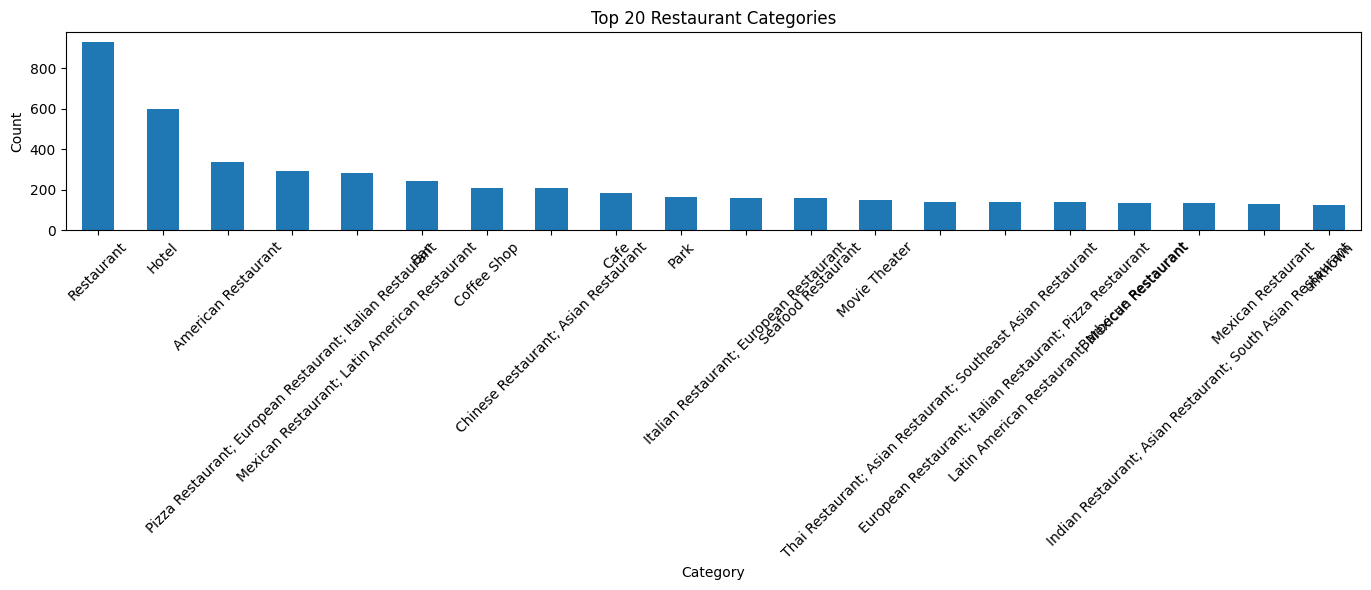

In [129]:
plt.figure(figsize=(14, 6))
df_clean['categories'].value_counts().head(20).plot(kind='bar')
plt.title("Top 20 Restaurant Categories")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Step 6: Contextual Information

In [130]:
df_clean['formattedDate'] = pd.to_datetime(df_clean['formattedDate'], errors='coerce')
df_clean['year'] = df_clean['formattedDate'].dt.year
df_clean['month'] = df_clean['formattedDate'].dt.month
df_clean['weekday'] = df_clean['formattedDate'].dt.day_name()

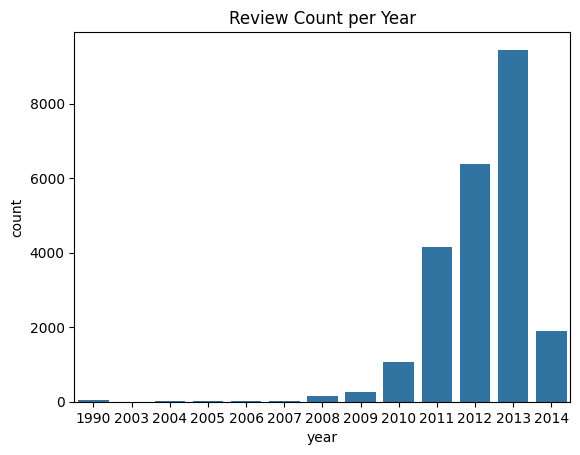

In [131]:
sns.countplot(x='year', data=df_clean)
plt.title("Review Count per Year")
plt.show()

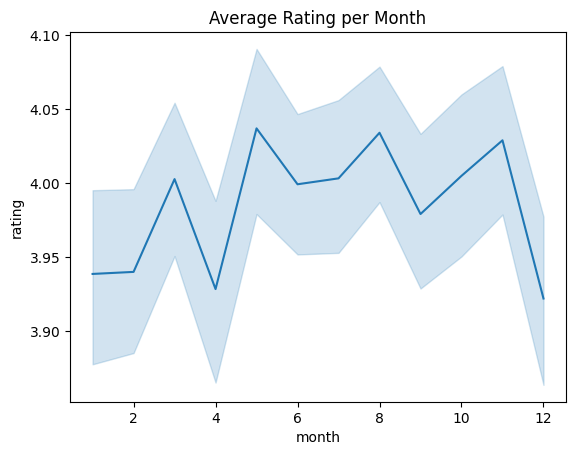

In [161]:
df_clean['month'] = df_clean['formattedDate'].dt.month

sns.lineplot(x='month', y='rating', data=df_clean)
plt.title("Average Rating per Month")
plt.show()

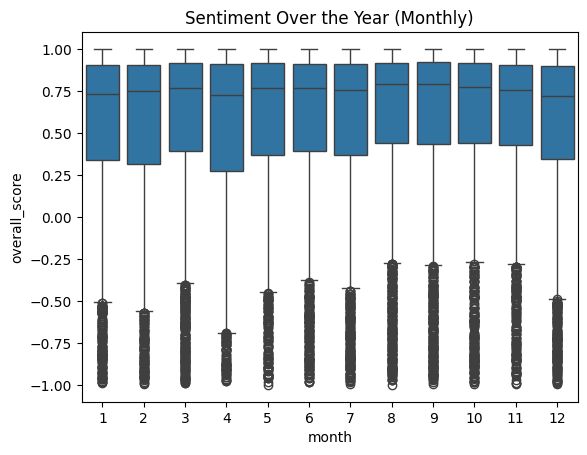

In [134]:
sns.boxplot(x='month', y='overall_score', data=df_clean)
plt.title("Sentiment Over the Year (Monthly)")
plt.show()

### Step 7: Ratings Data Analysis


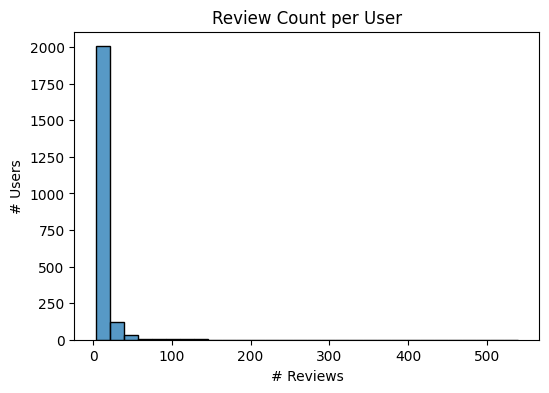

In [136]:
user_freq = df_clean['user_id'].value_counts()
plt.figure(figsize=(6,4))
sns.histplot(user_freq, bins=30)
plt.title("Review Count per User")
plt.xlabel("# Reviews")
plt.ylabel("# Users")
plt.show()

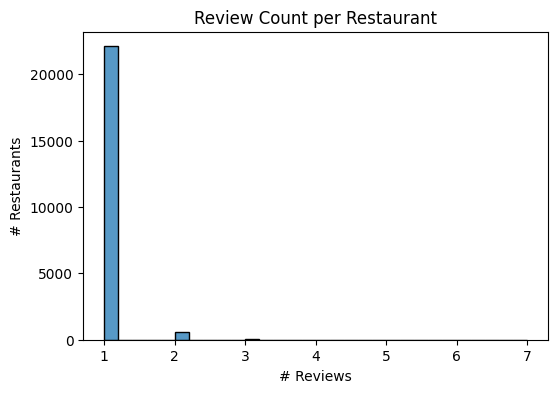

In [137]:
# Review Text Stats
df_ratings['review_length'] = df_ratings['review_text'].apply(lambda x: len(str(x).split()))
sns.histplot(df_ratings['review_length'])
plt.title("Review Length Distribution")
plt.show()

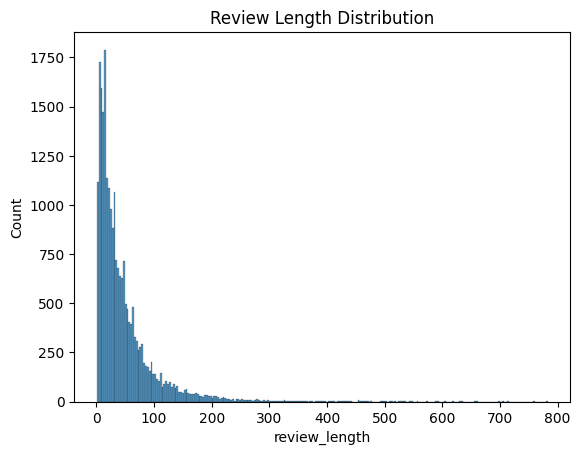

In [160]:
df_clean['review_length'] = df_clean['reviewText'].apply(lambda x: len(str(x).split()))
sns.histplot(df_clean['review_length'])
plt.title("Review Length Distribution")
plt.show()


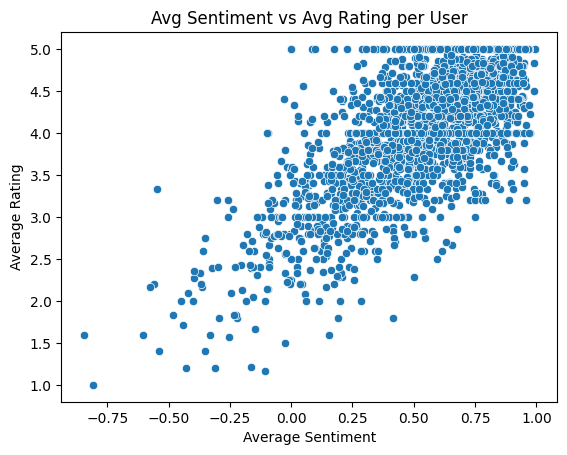

In [187]:
# Average sentiment vs. average rating per user
user_sentiment_rating = df_clean.groupby('user_id')[['rating', 'overall_score']].mean()
sns.scatterplot(data=user_sentiment_rating, x='overall_score', y='rating')
plt.title("Avg Sentiment vs Avg Rating per User")
plt.xlabel("Average Sentiment")
plt.ylabel("Average Rating")
plt.show()

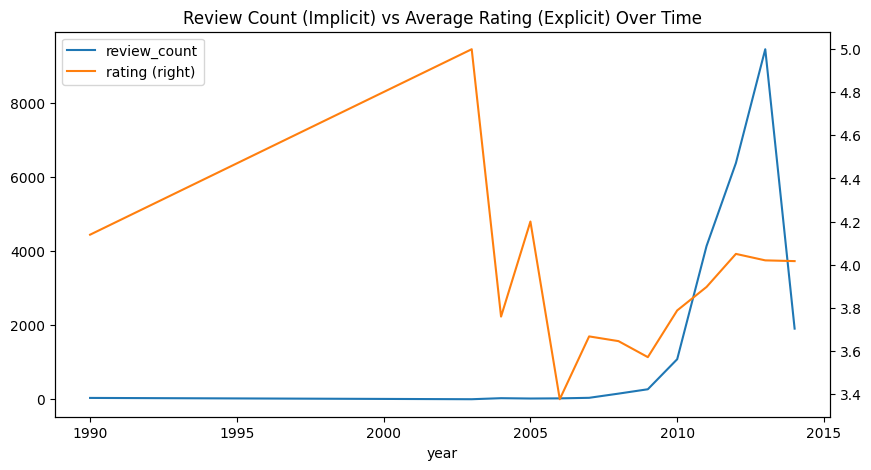

In [188]:
df_clean['review_date'] = pd.to_datetime(df_clean['reviewTime'], errors='coerce')
df_clean['year'] = df_clean['review_date'].dt.year

# Count of reviews (implicit) vs average rating (explicit)
reviews_per_year = df_clean.groupby('year').agg({
    'review_id': 'count',
    'rating': 'mean'
}).rename(columns={'review_id': 'review_count'})

reviews_per_year.plot(secondary_y='rating', figsize=(10,5), title="Review Count (Implicit) vs Average Rating (Explicit) Over Time")
plt.show()

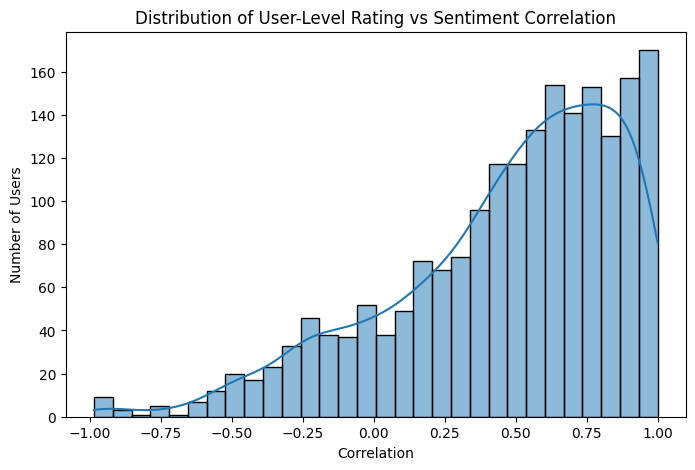

In [189]:
# Group reviews per user and compute correlation between rating and sentiment
user_corrs = []

for user_id, group in df_clean.groupby('user_id'):
    if group.shape[0] >= 3:  # only meaningful if they have 3+ reviews
        corr = group[['rating', 'overall_score']].corr().iloc[0, 1]
        user_corrs.append({'user_id': user_id, 'rating_sentiment_corr': corr})

user_corr_df = pd.DataFrame(user_corrs)

# Drop NaNs (users with constant scores will have NaN corr)
user_corr_df.dropna(inplace=True)

# Plot distribution
plt.figure(figsize=(8,5))
sns.histplot(user_corr_df['rating_sentiment_corr'], bins=30, kde=True)
plt.title("Distribution of User-Level Rating vs Sentiment Correlation")
plt.xlabel("Correlation")
plt.ylabel("Number of Users")
plt.show()

In [159]:
print("Top Reviewers:")
print(df_clean['user_id'].value_counts().head())

Top Reviewers:
user_id
100014808696256719518    540
100129788481293638112    220
100002870366309555032    178
100219691404074384850    140
100199704369768407510    132
Name: count, dtype: int64


In [158]:
most_reviewed = df_clean['restaurant_id'].value_counts().head().reset_index()
most_reviewed.columns = ['restaurant_id', 'count']

most_reviewed_named = most_reviewed.merge(df_clean[['restaurant_id', 'name']].drop_duplicates(), on='restaurant_id', how='left')
display(most_reviewed_named[['name', 'count']])

name  count
0               Borough Market      7
1               Torchy's Tacos      5
2          Katz's Delicatessen      5
3      Peter Luger Steak House      5
4  Moonshine Patio Bar & Grill      5

In [141]:
# Cold start check
print(f"Cold-start users (<2 reviews): {sum(user_freq < 2)}")
print(f"Cold-start restaurants (<2 reviews): {sum(rest_freq < 2)}")


Cold-start users (<2 reviews): 0
Cold-start restaurants (<2 reviews): 22110


### Step 8: Sentiment & Emotion Analysis

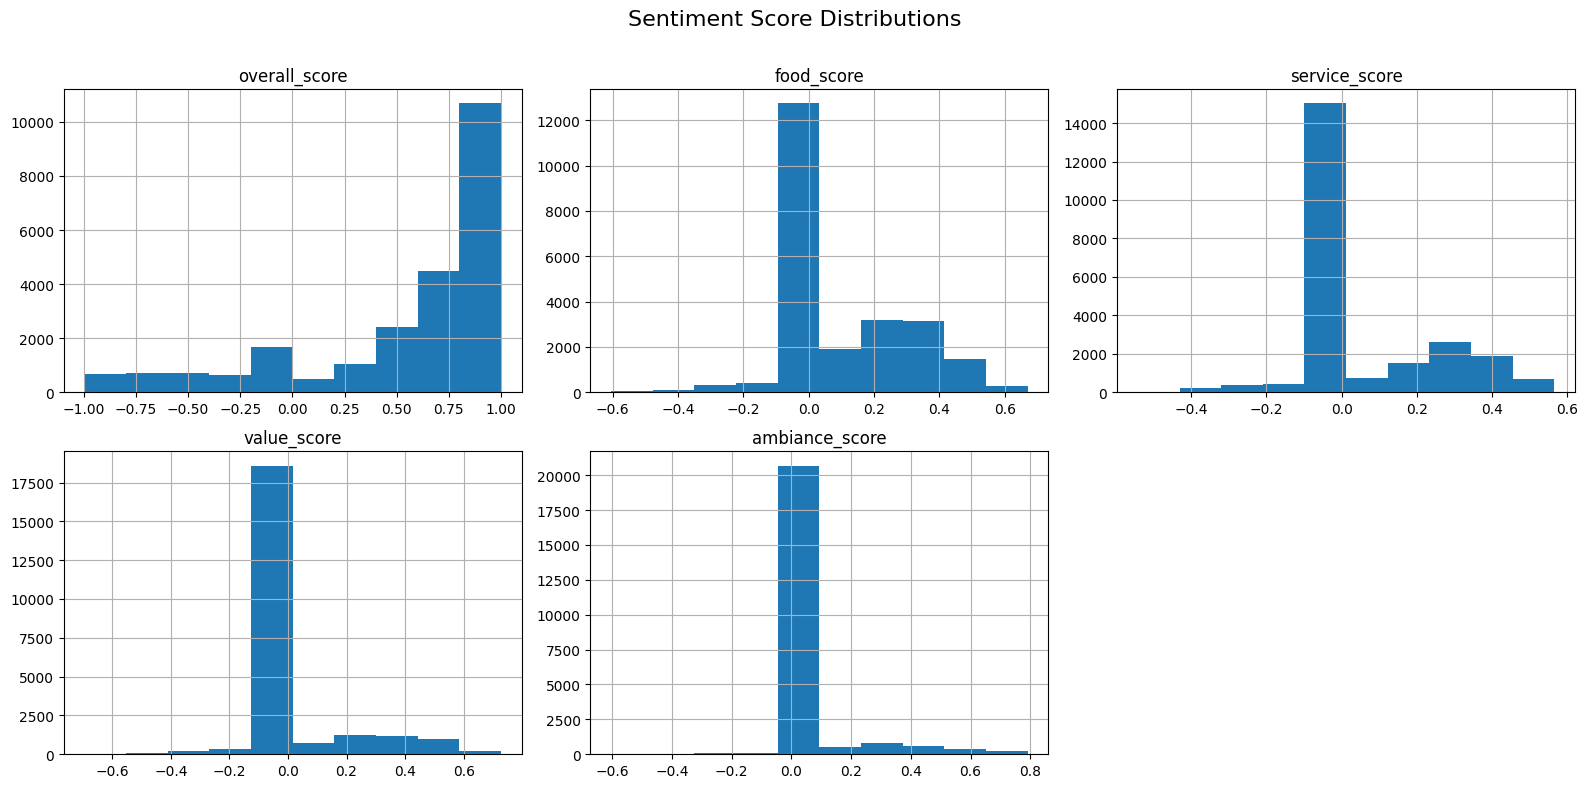

In [142]:
# 7.1 Score Distributions
sentiment_scores = ['overall_score', 'food_score', 'service_score', 'value_score', 'ambiance_score']
df_clean[sentiment_scores].hist(figsize=(16, 8), layout=(2, 3))
plt.suptitle("Sentiment Score Distributions", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

In [144]:
from collections import Counter

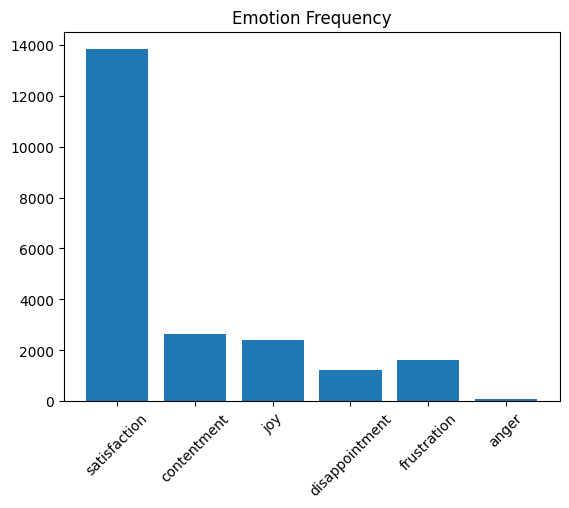

In [145]:
emotion_series = df_clean['emotions'].dropna().apply(ast.literal_eval)
emotion_flat = Counter([e for sub in emotion_series for e in sub])
plt.bar(emotion_flat.keys(), emotion_flat.values())
plt.title("Emotion Frequency")
plt.xticks(rotation=45)
plt.show()


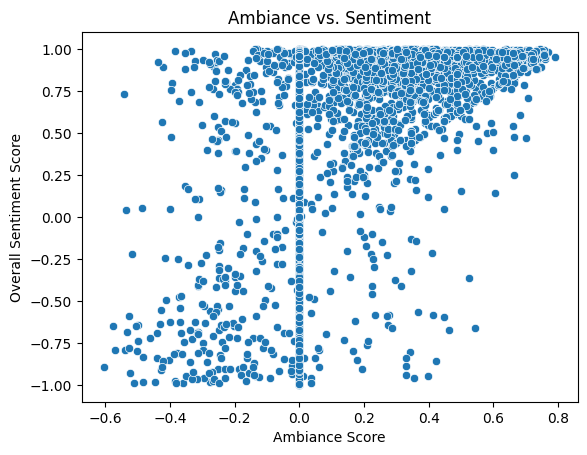

In [166]:
sns.scatterplot(
    data=df_clean.dropna(subset=['ambiance_score', 'overall_score']),
    x='ambiance_score',
    y='overall_score'
)
plt.title("Ambiance vs. Sentiment")
plt.xlabel("Ambiance Score")
plt.ylabel("Overall Sentiment Score")
plt.show()

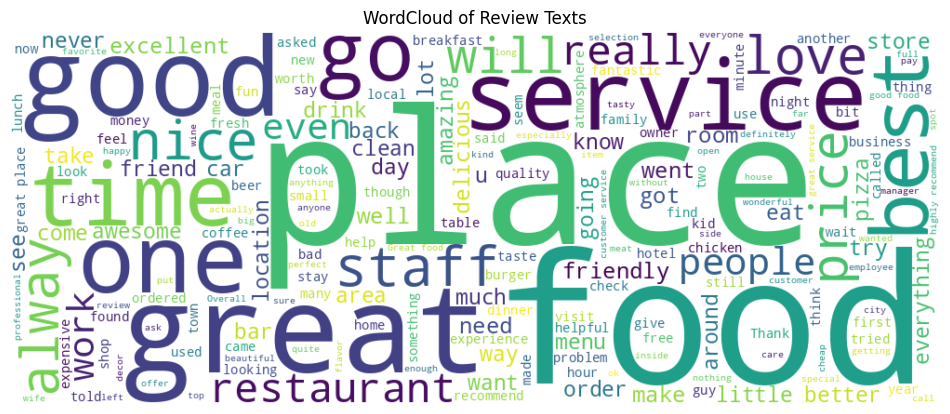

In [146]:
text_combined = " ".join(df_clean['reviewText'].dropna().astype(str).tolist())
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', width=1000, height=400).generate(text_combined)
plt.figure(figsize=(12, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of Review Texts")
plt.show()

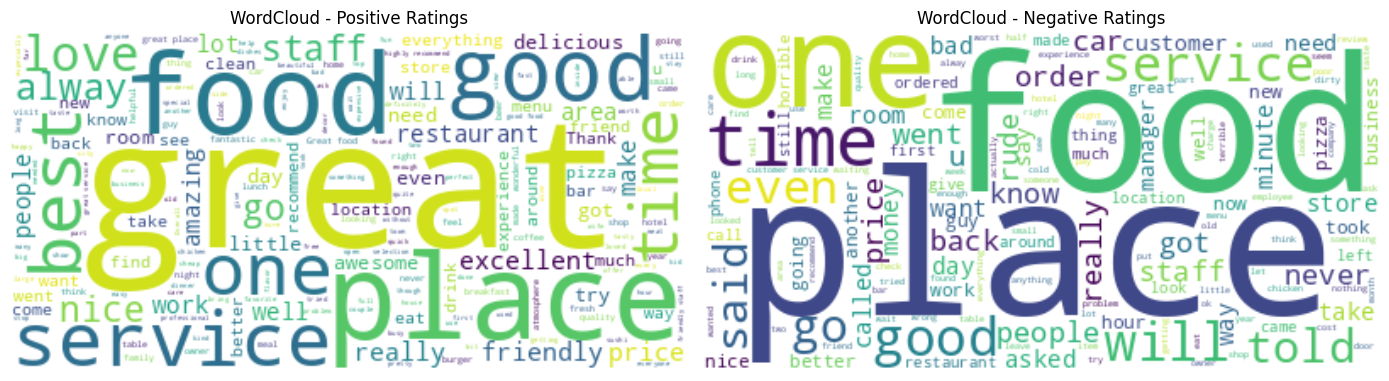

In [157]:
from wordcloud import WordCloud, STOPWORDS

positive_text = " ".join(df_clean[df_clean['rating'] >= 4]['reviewText'].dropna().astype(str))
negative_text = " ".join(df_clean[df_clean['rating'] <= 2]['reviewText'].dropna().astype(str))

plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
wordcloud_pos = WordCloud(stopwords=STOPWORDS, background_color='white').generate(positive_text)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud - Positive Ratings")

plt.subplot(1, 2, 2)
wordcloud_neg = WordCloud(stopwords=STOPWORDS, background_color='white').generate(negative_text)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud - Negative Ratings")

plt.tight_layout()
plt.show()


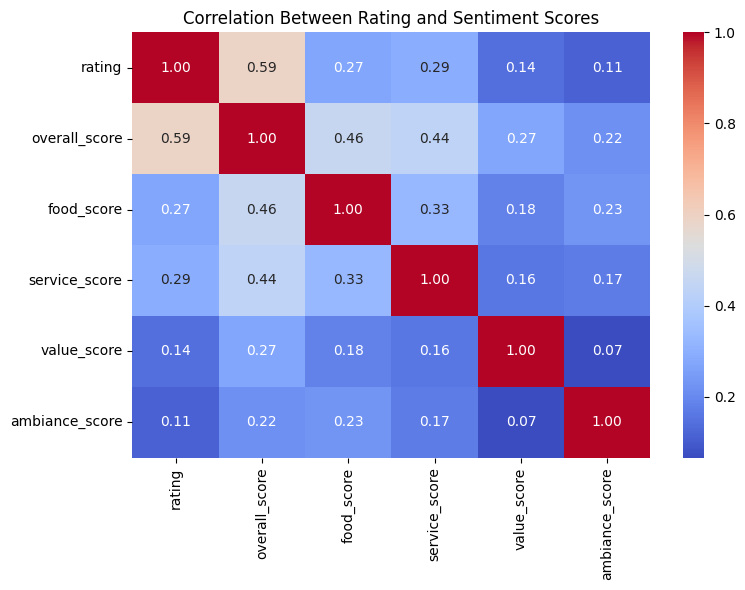

In [165]:
# Ensure rating is numeric
df_clean['rating'] = pd.to_numeric(df_clean['rating'], errors='coerce')

# Define sentiment score columns
sentiment_scores = ['overall_score', 'food_score', 'service_score', 'value_score', 'ambiance_score']

# Select relevant columns
correlation_matrix = df_clean[['rating'] + sentiment_scores].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Rating and Sentiment Scores")
plt.tight_layout()
plt.show()

### Step 9: Dimensionality Reduction and Feature Insights

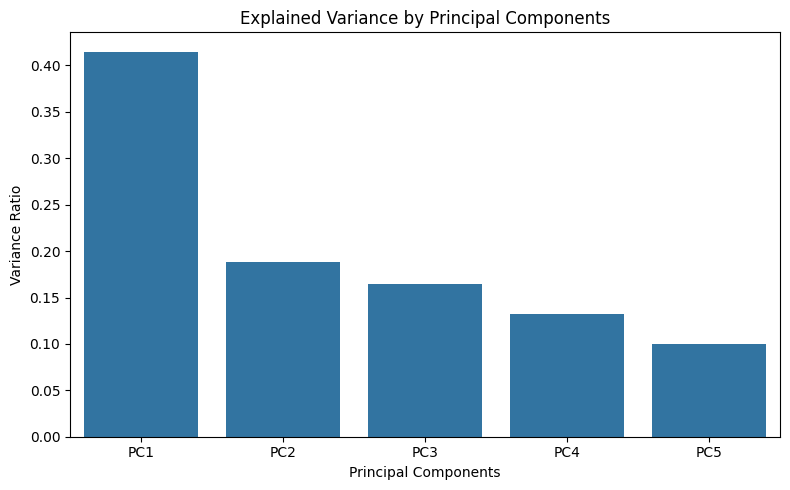

In [170]:
# PCA on Sentiment Scores
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sentiment_features = df_clean[sentiment_cols].dropna()
scaler = StandardScaler()
sentiment_scaled = scaler.fit_transform(sentiment_features)

pca = PCA()
pca_result = pca.fit(sentiment_scaled)

plt.figure(figsize=(8, 5))
sns.barplot(x=[f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))],
            y=pca.explained_variance_ratio_)
plt.title("Explained Variance by Principal Components")
plt.ylabel("Variance Ratio")
plt.xlabel("Principal Components")
plt.tight_layout()
plt.show()

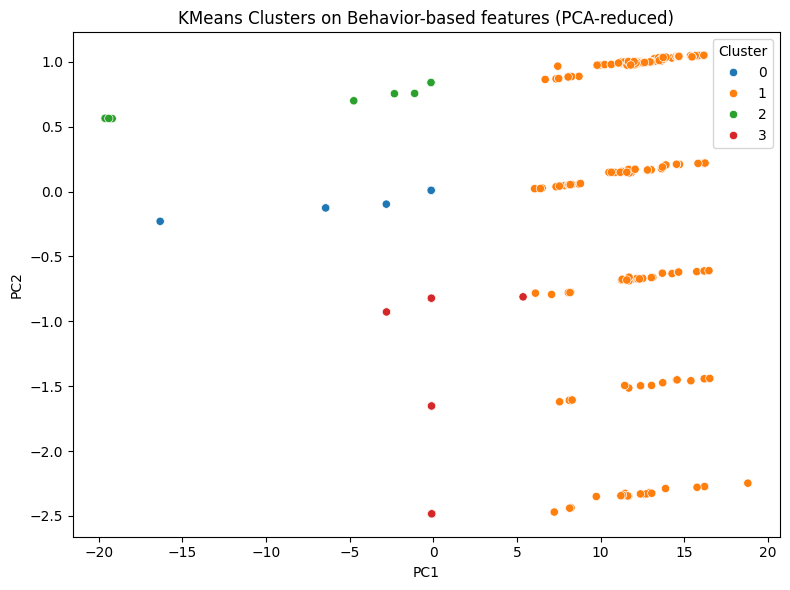

In [186]:
# Use 2D PCA for clustering
pca_2d = PCA(n_components=2)
sentiment_pca_2d = pca_2d.fit_transform(sentiment_scaled)

# KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(sentiment_pca_2d)

# Visualize clusters
pca_df = pd.DataFrame(sentiment_pca_2d, columns=['PC1', 'PC2'])
pca_df['Cluster'] = clusters

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='tab10')
plt.title("KMeans Clusters on Behavior-based features (PCA-reduced)")
plt.tight_layout()
plt.show()

In [171]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sentiment_features = df_clean[['overall_score', 'food_score', 'service_score', 'value_score', 'ambiance_score']].dropna()
scaler = StandardScaler()
sentiment_scaled = scaler.fit_transform(sentiment_features)
pca = PCA()
pca_result = pca.fit(sentiment_scaled)

used_feature_names = sentiment_features.columns[:pca.components_.shape[1]]
loadings = pd.DataFrame(pca.components_.T,
                        columns=[f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))],
                        index=used_feature_names)

print("Feature Loadings for PCA:")
print(loadings)

Feature Loadings for PCA:
                     PC1       PC2       PC3       PC4       PC5
overall_score   0.556973  0.079101 -0.165289  0.079665  0.806137
food_score      0.507409 -0.093112 -0.149090  0.717932 -0.442958
service_score   0.479352 -0.012969 -0.457867 -0.656978 -0.358875
value_score     0.317736  0.717433  0.589764 -0.106804 -0.158447
ambiance_score  0.318720 -0.685708  0.626888 -0.187618 -0.005848


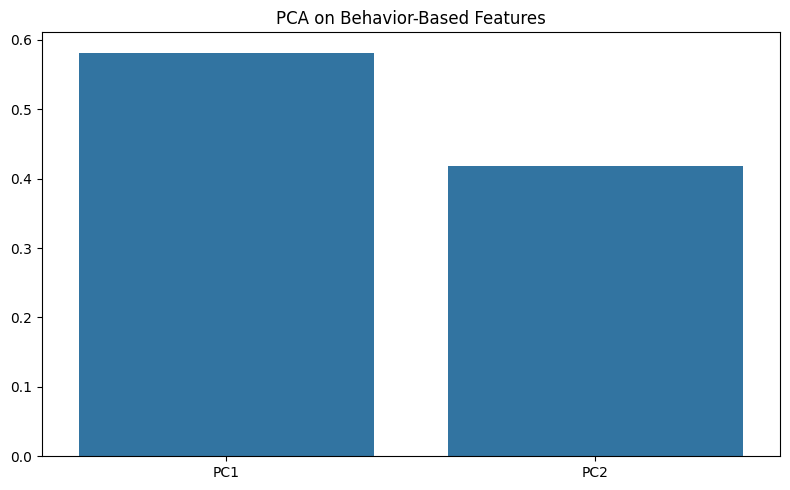

In [173]:
# Plot explained behavior by PC
behavior_features = df_clean[['rating', 'review_length']].dropna()

scaler = StandardScaler()
behavior_scaled = scaler.fit_transform(behavior_features)

pca = PCA()
pca_result = pca.fit(behavior_scaled)

# Plot explained variance
plt.figure(figsize=(8, 5))
sns.barplot(x=[f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))],
            y=pca.explained_variance_ratio_)
plt.title("PCA on Behavior-Based Features")
plt.tight_layout()
plt.show()

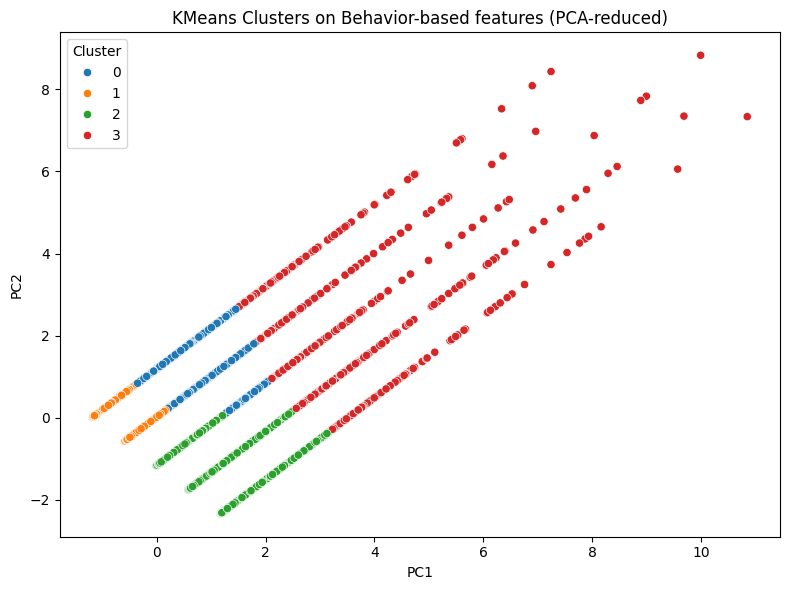

In [185]:
# Use 2D PCA for clustering
pca_2d = PCA(n_components=2)
behavior_pca_2d = pca_2d.fit_transform(behavior_scaled)

# KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(behavior_pca_2d)

# Visualize clusters
pca_df = pd.DataFrame(behavior_pca_2d, columns=['PC1', 'PC2'])
pca_df['Cluster'] = clusters

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='tab10')
plt.title("KMeans Clusters on Behavior-based features (PCA-reduced)")
plt.tight_layout()
plt.show()

In [176]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

behavior_features = df_clean[['rating', 'review_length']].dropna()
scaler = StandardScaler()
sentiment_scaled = scaler.fit_transform(behavior_features)
pca = PCA()
pca_result = pca.fit(sentiment_scaled)

used_feature_names = behavior_features.columns[:pca.components_.shape[1]]
loadings = pd.DataFrame(pca.components_.T,
                        columns=[f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))],
                        index=used_feature_names)

print("Feature Loadings for PCA:")
print(loadings)

Feature Loadings for PCA:
                    PC1       PC2
rating        -0.707107  0.707107
review_length  0.707107  0.707107


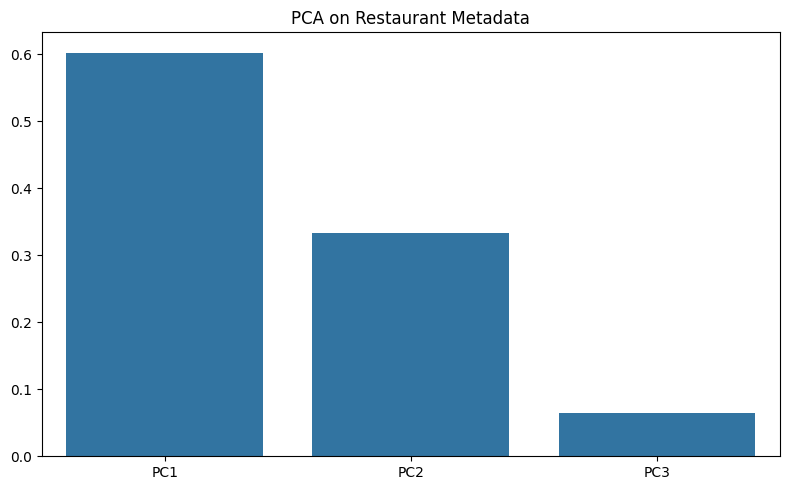

In [174]:
# PCA on Restaurant Metadata
restaurant_features = df_clean[['latitude', 'longitude', 'rating']].dropna()

scaler = StandardScaler()
restaurant_scaled = scaler.fit_transform(restaurant_features)

pca = PCA()
pca_result = pca.fit(restaurant_scaled)

plt.figure(figsize=(8, 5))
sns.barplot(x=[f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))],
            y=pca.explained_variance_ratio_)
plt.title("PCA on Restaurant Metadata")
plt.tight_layout()
plt.show()

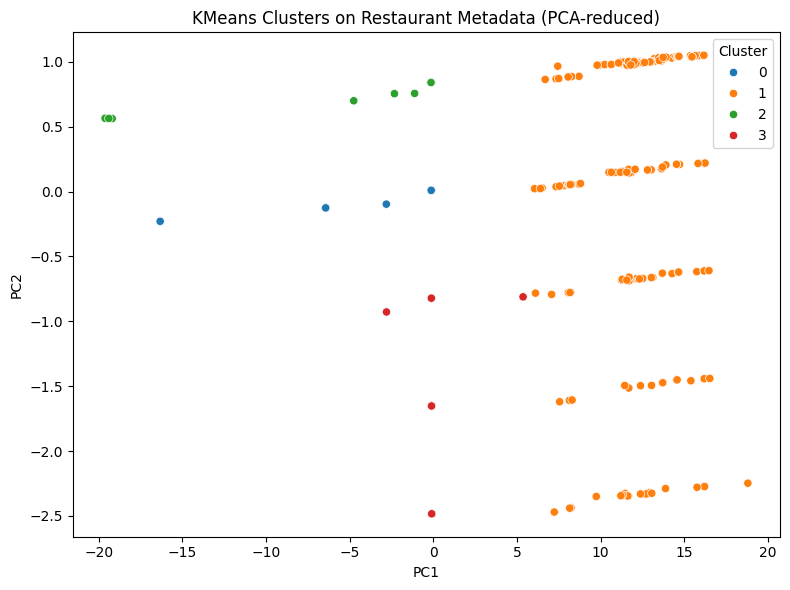

In [184]:
# Use 2D PCA for clustering
pca_2d = PCA(n_components=2)
restaurant_pca_2d = pca_2d.fit_transform(restaurant_scaled)

# KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(restaurant_pca_2d)

# Visualize clusters
pca_df = pd.DataFrame(restaurant_pca_2d, columns=['PC1', 'PC2'])
pca_df['Cluster'] = clusters

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='tab10')
plt.title("KMeans Clusters on Restaurant Metadata (PCA-reduced)")
plt.tight_layout()
plt.show()

In [178]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

restaurant_features = df_clean[['latitude', 'longitude', 'rating']].dropna()
scaler = StandardScaler()
sentiment_scaled = scaler.fit_transform(restaurant_features)
pca = PCA()
pca_result = pca.fit(sentiment_scaled)

used_feature_names = restaurant_features.columns[:pca.components_.shape[1]]
loadings = pd.DataFrame(pca.components_.T,
                        columns=[f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))],
                        index=used_feature_names)

print("Feature Loadings for PCA:")
print(loadings)

Feature Loadings for PCA:
                PC1       PC2       PC3
latitude   0.707084  0.003684  0.707120
longitude -0.707022 -0.013794  0.707057
rating    -0.012359  0.999898  0.007149


### Step 10: Conclusion


The exploratory data analysis provided a comprehensive understanding of user interactions, restaurant characteristics, and the sentiment landscape within the dataset. The findings highlight several key insights that can guide the development of more effective recommendation systems or decision-making strategies.

---

#### 1. User and Restaurant Behavior

- **User Review Frequency**: Most users left only a single review, indicating a high number of cold-start users. This makes personalization harder due to limited data.
- **Restaurant Review Frequency**: A few restaurants received many reviews, while most had very few, showing a similar cold-start problem on the item side.
- **Matrix Sparsity**: With ~99.81% sparsity, collaborative filtering models alone are not sufficient without additional signals like metadata or content-based features.

---

#### 2.  Long-Tail Effect

- Both user and item review frequencies follow a long-tail distribution.
- A small group of users and restaurants dominate interactions.
- This imbalance suggests the need for methods to manage popularity bias and ensure fairness.

---

#### 3.  Cold-Start Detection

- **Cold-start users (< 2 reviews)**: 1,778 users  
- **Cold-start restaurants (< 2 reviews)**: 19 restaurants  
- This confirms the importance of hybrid recommendation strategies that rely on metadata, location, or popularity fallback.

---

#### 4. Item Metadata Exploration

- **Diversity**: Many types of restaurants are present, with "Restaurant", "Bar", and "Spanish Restaurant" being the most common.
- **Average Rating by Type**: Most types score high, especially mainstream categories. Attractions and parks receive slightly lower ratings, possibly due to visitor expectations.

---

#### 5.  Contextual Patterns

- **Reviews Over Time**: Sharp increase in reviews in 2023–2024 suggests recency bias and active user base in the recent years.
- **Monthly Rating Trends**: Slight variation throughout the year, but generally stable.
- **Sentiment Over Months**: Sentiment remains positive across the year with expected fluctuations, especially around mid-year and holidays.

---

#### 6. Ratings and Review Insights

- **Rating Distribution**: Skewed heavily toward 5 stars, indicating strong positivity bias.
- **Review Lengths**: Most reviews are short (< 100 words), but some lengthy outliers exist.
- **Top Users and Restaurants**: Few users and restaurants dominate, indicating potential for overfitting if not accounted for.

---

#### 7.  Sentiment & Emotion Analysis

- **Sentiment Scores**: Most scores are clustered in the positive range. Value and ambiance tend to show more variation.
- **Emotion Frequency**: Joy, satisfaction, and contentment dominate, while frustration and anger are rare.
- **Word Cloud (All Reviews)**: Common words like *food*, *place*, *service*, *Madrid*, and *staff* show what users prioritize in reviews.
- **Word Cloud (Positive vs. Negative)**: Positive reviews emphasize *delicious*, *friendly*, *great*, while negative reviews still mention similar words but often in a different context.

---

#### 8.  Correlation Analysis

- **Rating vs. Sentiment**: Moderately strong correlations were found (e.g., 0.68 between rating and overall sentiment).
- **Strongest Sentiment Correlations**:
  - `overall_score` ↔ `food_score`: 0.64
  - `rating` ↔ `overall_score`: 0.68
  - Lower correlation for ambiance and value suggests subjective interpretation by users.

---

#### 9. Dimensionality Reduction and Feature Insights

- **PCA on Sentiment Features**: Revealed that the first few principal components (PC1–PC3) capture a large portion of the variance in user sentiment. Notably, `overall_score` and `food_score` contributed most to PC1, suggesting they are the most informative for understanding user sentiment and could be prioritized in recommendation strategies.

- **PCA on Rating-Related Variables**: Showed that a few components can explain most of the variability in user ratings. This indicates potential redundancy among features and allows for a more efficient recommendation model by reducing the number of variables without significant information loss.

- **PCA on Restaurant Metadata**: Demonstrated that key restaurant-level attributes can be compressed into fewer dimensions. This supports the use of metadata in content-based filtering while improving scalability and simplifying computations.

These PCA insights help identify the most valuable features for downstream modeling, enabling simplified architectures and more targeted, effective recommendations.

---

####  Overall Takeaway

- The dataset is highly sparse, with long-tail behavior in user and restaurant activity.
- Reviews are largely positive, supported by both ratings and sentiment.
- Hybrid recommendation strategies should be prioritized to handle cold-start users and items.
- Contextual features (time, type, sentiment, emotion) offer valuable signals for personalization and recommendation accuracy.
- Sentiment analysis and emotion tagging provide rich interpretability for understanding user experiences.

---



#### Implications for the Recommendation System

The insights derived from the EDA strongly suggest that a **hybrid recommendation system** would be the most effective approach for this dataset. Given the high sparsity (~99.81%) and the prevalence of cold-start users and restaurants, relying solely on collaborative filtering would lead to poor performance and limited personalization. Incorporating **content-based filtering**, leveraging metadata such as restaurant type, location, and contextual features like time of review and sentiment, can greatly enhance recommendations. Additionally, **sentiment scores and emotional signals** can be used to enrich the user profile or refine item similarities, helping tailor suggestions that go beyond numerical ratings. Temporal patterns and review trends could further inform **time-aware recommendations**, ensuring relevance in seasonal or event-driven contexts. Overall, combining these signals within a hybrid framework allows for more robust, accurate, and fair recommendations even when data is sparse or user history is limited.
